In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import os.path
from os import path

/home/zeus/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zeus/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def start():
    if(path.exists('reduced_dataset_for_LSTM.csv')==True):
        return 
    df=pd.read_csv('household_power_consumption.txt', delimiter=';')
    df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
    df = df.dropna(subset=['Global_active_power'])
    df['date_time']=pd.to_datetime(df['date_time']) 
    df['year'] = df['date_time'].apply(lambda x: x.year)
    df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
    df['month'] = df['date_time'].apply(lambda x: x.month)
    df['day'] = df['date_time'].apply(lambda x: x.day)
    df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
    df.sort_values('date_time', inplace=True, ascending=True)
    df = df.reset_index(drop=True)
    df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
    df["weekday"] = (df["weekday"] < 5).astype(int)
    df.to_csv('reduced_dataset_for_LSTM.csv')
    return df

In [3]:
def resume():
    df=pd.read_csv('reduced_dataset_for_LSTM.csv')
    return df

In [4]:
df=start()  # Running first time this may take some time 

In [5]:
df=resume()

In [6]:
dataset = df.Global_active_power.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_train.shape
Y_train.shape
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 1639393 samples, validate on 409825 samples
Epoch 1/15
1639393/1639393 [==============================] - 87s 53us/step - loss: 7.6881e-04 - val_loss: 4.4847e-04
Epoch 2/15
1639393/1639393 [==============================] - 85s 52us/step - loss: 6.6575e-04 - val_loss: 4.3362e-04
Epoch 3/15
1639393/1639393 [==============================] - 85s 52us/step - loss: 6.5555e-04 - val_loss: 4.6709e-04
Epoch 4/15
1639393/1639393 [==============================] - 86s 53us/step - loss: 6.4902e-04 - val_loss: 4.4664e-04
Epoch 5/15
1639393/1639393 [==============================] - 86s 52us/step - loss: 6.4291e-04 - val_loss: 4.1695e-04
Epoch 6/15
1639393/1639393 [==============================] - 87s 53us/step - loss: 6.4023e-04 - val_loss: 4.4175e-04
Epoch 7/15
1639393/1639393 [==============================] - 87s 53us/step - loss: 6.3735e-04 - val_loss: 4.2133e-04
Epoch 8/15
1639393/1639393 [==============================] - 87s 53us/step - loss: 6.3518e-04 - val_loss: 4.2790e-04
Epo

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11808802188629211
Train Root Mean Squared Error: 0.26961159646051824
Test Mean Absolute Error: 0.10521258418496064
Test Root Mean Squared Error: 0.22441674711056028


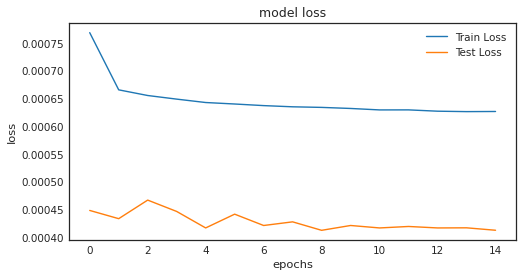

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

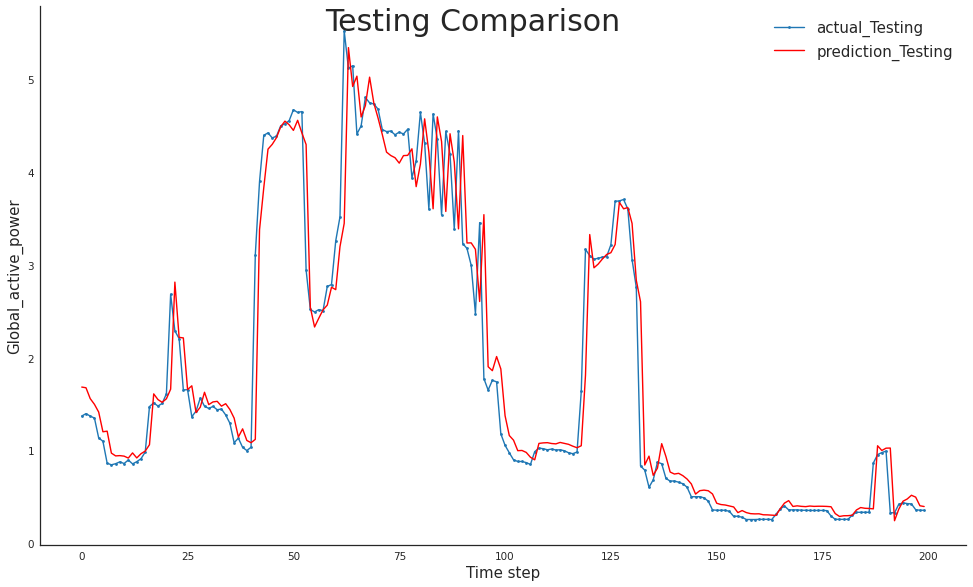

In [19]:
aa=[x for x in range(200)]
fig=plt.figure(figsize=(14,8))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual_Testing")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction_Testing")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
fig.suptitle('Testing Comparison', fontsize=30)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

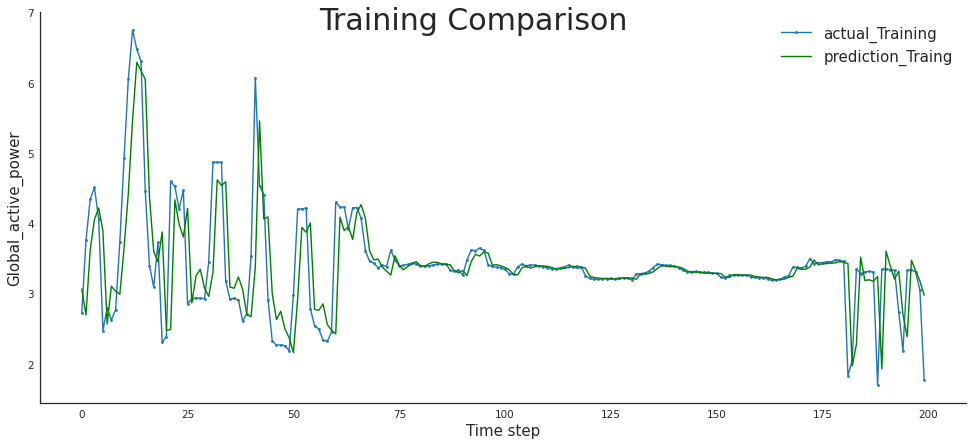

In [20]:
aa=[x for x in range(200)]
fig=plt.figure(figsize=(14,6))
plt.plot(aa, Y_train[0][:200], marker='.', label="actual_Training")
plt.plot(aa, train_predict[:,0][:200], 'g', label="prediction_Traing")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
fig.suptitle('Training Comparison', fontsize=30)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();